In [2]:
import itertools
import random
import time

%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../../../")

import pandas as pd
from statistics import mean

import mpire
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from collections import defaultdict
from baselines.kbqa.subgraph_retriever import NHopRetriever, FilteredTriplesNHopRetriever
from baselines.kbqa.data import load_dataset, load_graph
from baselines.defaults import KBQA_BASELINES_PATH
import seaborn as sns

## Load data

In [4]:
def calculate_stats(subgraph, dataset_name, graph_hop, retriever_cls, k, answers, retriever_hop):
    entities_in_subgraph = np.unique(subgraph[:, [0, 2]])
    in_subgraph = mean([1.0 if a in entities_in_subgraph else 0.0 for a in answers])

    return {
        "dataset": dataset_name,
        "graph_hop": graph_hop,
        "retriever": retriever_cls.__name__,
        "retriever_hop": retriever_hop,
        "k": k,
        "subgraph_size": len(subgraph),
        "contains_answer": in_subgraph,
    }


def calculate_stats_for_dataset(worker_id, dataset_name, graph_hop, retriever_hop, batch):
    time.sleep(15 * worker_id)
    print(dataset_name, graph_hop, retriever_hop, batch)
    dataset = load_dataset(dataset_name)

    triples, labels = load_graph(graph_hop)
    triples = np.array(triples)

    print("Loading tensors...")
    queries_emb = torch.load(
        KBQA_BASELINES_PATH / f"embeddings/emb_{dataset_name}_train.pt",
        map_location=torch.device("cpu"),
    )
    triples_emb = torch.load(
        KBQA_BASELINES_PATH / f"embeddings/emb_triples_hop_{graph_hop}.pt",
        map_location=torch.device("cpu"),
    )
    df = pd.DataFrame(dataset["train"]).head(500)[batch : batch + 50]

    stats = []
    print("Initializing NHopRetriever...")
    n_hop_retriever = NHopRetriever(retriever_hop, triples)
    print("Initializing FilteredTriplesNHopRetriever...")
    filtered_triples_retriever = FilteredTriplesNHopRetriever(
        2, triples, labels=labels, triples_emb=triples_emb
    )
    for example in tqdm(df.itertuples(), total=len(df), desc=f"{worker_id}:"):
        topic = example.topic
        answers = example.answer

        base_subgraph = n_hop_retriever.retrieve(topic)
        stats.append(
            calculate_stats(
                base_subgraph, dataset_name, graph_hop, NHopRetriever, None, answers, retriever_hop
            )
        )

        for i, k in enumerate([5, 10, 20, 40, 80]):
            subgraph = filtered_triples_retriever.retrieve_for_subgraph(
                base_subgraph, query_emb=queries_emb[example.Index], k_triples=k
            )
            stats.append(
                calculate_stats(
                    subgraph,
                    dataset_name,
                    graph_hop,
                    FilteredTriplesNHopRetriever,
                    k,
                    answers,
                    retriever_hop,
                )
            )
    df = pd.DataFrame(stats)
    return pd.DataFrame(stats)

In [5]:
if (KBQA_BASELINES_PATH / "notebooks/subgraph_retrieval_results.csv").exists():
    df = pd.read_csv(KBQA_BASELINES_PATH / "notebooks/subgraph_retrieval_results.csv")
else:
    iter = list(
        itertools.product(
            ["kbqa_natural", "kbqa_template-based"], [2, 1], [3, 2, 1], range(0, 500, 50)
        )
    )
    random.Random(17).shuffle(iter)
    with mpire.WorkerPool(15, pass_worker_id=True) as pool:
        results = pool.map(
            calculate_stats_for_dataset,
            iter,
        )
    df = pd.concat(results)
    df.to_csv("subgraph_retrieval_results.csv")

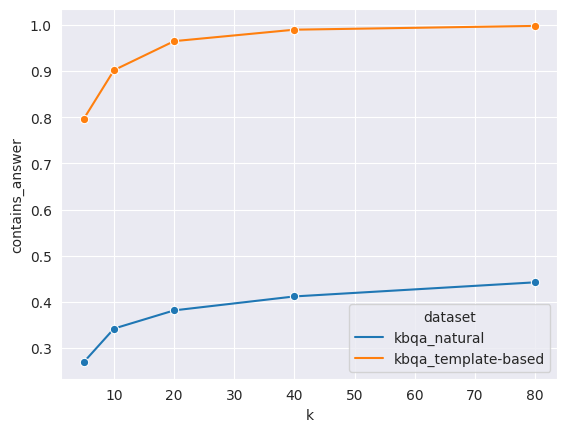

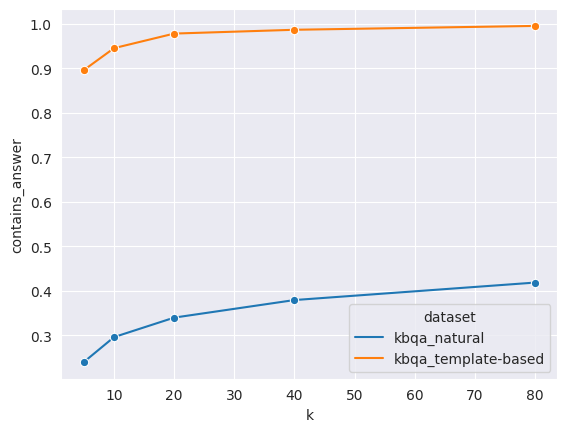

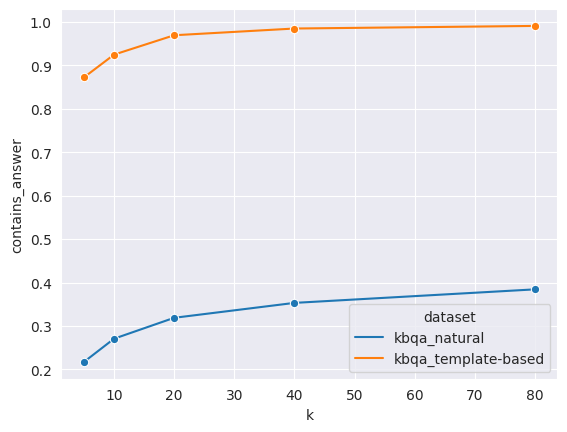

In [6]:
to_plot = df[df.graph_hop == 0]
sns.lineplot(
    data=to_plot.reset_index(), x="k", y="contains_answer", hue="dataset", marker="o", ci=None
)
plt.show()

to_plot = df[df.graph_hop == 1]
sns.lineplot(
    data=to_plot.reset_index(), x="k", y="contains_answer", hue="dataset", marker="o", ci=None
)
plt.show()

to_plot = df[df.graph_hop == 2]
sns.lineplot(
    data=to_plot.reset_index(), x="k", y="contains_answer", hue="dataset", marker="o", ci=None
)
plt.show()

In [7]:
df.describe()

,Unnamed: 0,graph_hop,retriever_hop,k,subgraph_size,contains_answer
count,54000.000000,54000.000000,54000.000000,45000.000000,5.400000e+04,54000.000000
mean,1499.500000,1.000000,2.000000,31.000000,5.734822e+04,0.670299
std,866.033375,0.816504,0.816504,27.276666,3.577357e+05,0.455803
min,0.000000,0.000000,1.000000,5.000000,0.000000e+00,0.000000
25%,749.750000,0.000000,1.000000,10.000000,1.000000e+01,0.000000
50%,1499.500000,1.000000,2.000000,20.000000,2.000000e+01,1.000000
75%,2249.250000,2.000000,3.000000,40.000000,6.325000e+01,1.000000
max,2999.000000,2.000000,3.000000,80.000000,4.721700e+06,1.000000


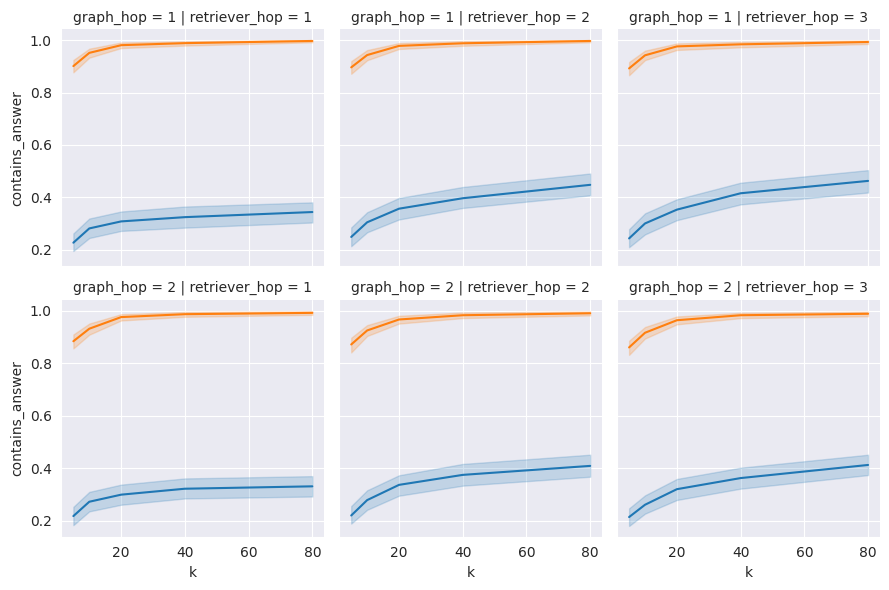

In [8]:
to_plot = df[df.graph_hop != 0]
g = sns.FacetGrid(to_plot, col="retriever_hop", row="graph_hop")
g.map(sns.lineplot, "k", "contains_answer", "dataset")

In [9]:
to_plot.groupby(
    ["dataset", "graph_hop", "retriever_hop", "retriever", "k"]
).contains_answer.mean().unstack()

k                                                                             5.0   \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.227279   
                              2             FilteredTriplesNHopRetriever  0.249197   
                              3             FilteredTriplesNHopRetriever  0.243623   
                    2         1             FilteredTriplesNHopRetriever  0.217660   
                              2             FilteredTriplesNHopRetriever  0.219915   
                              3             FilteredTriplesNHopRetriever  0.213930   
kbqa_template-based 1         1             FilteredTriplesNHopRetriever  0.900789   
                              2             FilteredTriplesNHopRetriever  0.895956   
                              3             FilteredTriplesNHopRetriever  0.891956   
                    2         1             FilteredTriplesNHopRetriever  0.884456   
                              2             FilteredTriplesNHopRetriever  0.872170   
                              3             FilteredTriplesNHopRetriever  0.860884   

k                                                                             10.0  \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.281712   
                              2             FilteredTriplesNHopRetriever  0.305094   
                              3             FilteredTriplesNHopRetriever  0.300667   
                    2         1             FilteredTriplesNHopRetriever  0.272355   
                              2             FilteredTriplesNHopRetriever  0.278610   
                              3             FilteredTriplesNHopRetriever  0.260867   
kbqa_template-based 1         1             FilteredTriplesNHopRetriever  0.951235   
                              2             FilteredTriplesNHopRetriever  0.942902   
                              3             FilteredTriplesNHopRetriever  0.941902   
                    2         1             FilteredTriplesNHopRetriever  0.932235   
                              2             FilteredTriplesNHopRetriever  0.925568   
                              3             FilteredTriplesNHopRetriever  0.916830   

k                                                                             20.0  \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.308496   
                              2             FilteredTriplesNHopRetriever  0.357005   
                              3             FilteredTriplesNHopRetriever  0.353350   
                    2         1             FilteredTriplesNHopRetriever  0.299344   
                              2             FilteredTriplesNHopRetriever  0.336726   
                              3             FilteredTriplesNHopRetriever  0.320252   
kbqa_template-based 1         1             FilteredTriplesNHopRetriever  0.980578   
                              2             FilteredTriplesNHopRetriever  0.977911   
                              3             FilteredTriplesNHopRetriever  0.975911   
                    2         1             FilteredTriplesNHopRetriever  0.976578   
                              2             FilteredTriplesNHopRetriever  0.967411   
                              3             FilteredTriplesNHopRetriever  0.964578   

k                                                                             40.0  \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.324719   
                              2             FilteredTriplesNHopRetriever  0.396827   
                              3          

In [12]:
to_plot.groupby(
    ["dataset", "graph_hop", "retriever_hop", "retriever", "k"]
).contains_answer.std().unstack()

k                                                                             5.0   \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.396862   
                              2             FilteredTriplesNHopRetriever  0.409095   
                              3             FilteredTriplesNHopRetriever  0.404223   
                    2         1             FilteredTriplesNHopRetriever  0.389312   
                              2             FilteredTriplesNHopRetriever  0.390315   
                              3             FilteredTriplesNHopRetriever  0.384516   
kbqa_template-based 1         1             FilteredTriplesNHopRetriever  0.268310   
                              2             FilteredTriplesNHopRetriever  0.275280   
                              3             FilteredTriplesNHopRetriever  0.279169   
                    2         1             FilteredTriplesNHopRetriever  0.291371   
                              2             FilteredTriplesNHopRetriever  0.306803   
                              3             FilteredTriplesNHopRetriever  0.320503   

k                                                                             10.0  \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.429172   
                              2             FilteredTriplesNHopRetriever  0.438444   
                              3             FilteredTriplesNHopRetriever  0.435774   
                    2         1             FilteredTriplesNHopRetriever  0.424427   
                              2             FilteredTriplesNHopRetriever  0.425472   
                              3             FilteredTriplesNHopRetriever  0.414487   
kbqa_template-based 1         1             FilteredTriplesNHopRetriever  0.195461   
                              2             FilteredTriplesNHopRetriever  0.213056   
                              3             FilteredTriplesNHopRetriever  0.213959   
                    2         1             FilteredTriplesNHopRetriever  0.233503   
                              2             FilteredTriplesNHopRetriever  0.244557   
                              3             FilteredTriplesNHopRetriever  0.255504   

k                                                                             20.0  \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.440573   
                              2             FilteredTriplesNHopRetriever  0.457635   
                              3             FilteredTriplesNHopRetriever  0.452895   
                    2         1             FilteredTriplesNHopRetriever  0.436862   
                              2             FilteredTriplesNHopRetriever  0.453050   
                              3             FilteredTriplesNHopRetriever  0.444223   
kbqa_template-based 1         1             FilteredTriplesNHopRetriever  0.125924   
                              2             FilteredTriplesNHopRetriever  0.134062   
                              3             FilteredTriplesNHopRetriever  0.141011   
                    2         1             FilteredTriplesNHopRetriever  0.140333   
                              2             FilteredTriplesNHopRetriever  0.165960   
                              3             FilteredTriplesNHopRetriever  0.172584   

k                                                                             40.0  \
dataset             graph_hop retriever_hop retriever                                
kbqa_natural        1         1             FilteredTriplesNHopRetriever  0.446194   
                              2             FilteredTriplesNHopRetriever  0.467880   
                              3          